In [11]:
# ------- Notebook config
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# ------- Load dependencies
import geopandas as gpd
import pandas as pd
import seaborn as sns

import rasterio
import os
from rasterstats import zonal_stats

# -------- Set working directory
wrkdir = 'Z:\Dan K\DinkeyCreek\LANDIS_RUNS\\'

Populating the interactive namespace from numpy and matplotlib


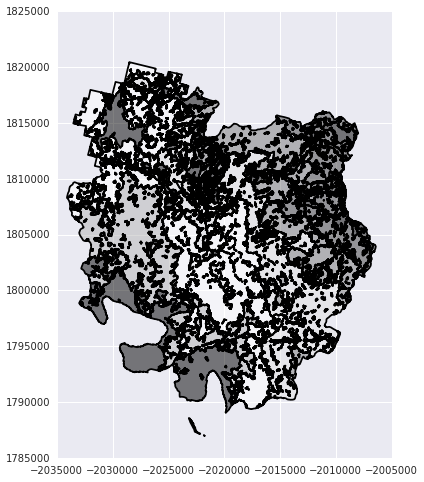

In [15]:
# Specify the name of our vector
mgmt = 'mgmtUnit_5070.shp'

mgmtUnits = gpd.GeoDataFrame.from_file(wrkdir + mgmt)
orig_crs = orig_zones.crs
orig_zones.plot()
sns.despine()
sns.set_style('ticks')